In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import shap
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle as pkl
import matplotlib.pyplot as plt
import ipywidgets as widgets

from datetime import datetime
from tqdm.auto import tqdm
from ipywidgets import interact, interactive
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from skimage.measure import block_reduce

from mlxtend.frequent_patterns import apriori, association_rules

2024-04-04 14:47:35.075186: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 14:47:35.093213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 14:47:35.093228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 14:47:35.093788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 14:47:35.097111: I tensorflow/core/platform/cpu_feature_guar

## Dataprovider

In [3]:
class MNISTData():
    def __init__(
            self,
            batch_size,
            num_batches,
            classes,
            num_classes,
            view1_train,
            view1_eval,
            view1_test,
            view2_train,
            view2_eval,
            view2_test,
            num_samples,
            dim_samples):
        
        self.batch_size = batch_size
        self.num_batches = num_batches
        self.classes = classes
        self.num_classes = num_classes
        self.view1_train = view1_train
        self.view1_eval = view1_eval
        self.view1_test = view1_test
        self.view2_train = view2_train
        self.view2_eval = view2_eval
        self.view2_test = view2_test
        self.num_samples = num_samples
        self.dim_samples = dim_samples

        self.training_data = self.get_dataset(view1_train, view2_train)
        self.eval_data = self.get_dataset(view1_eval, view2_eval)
        self.test_data = self.get_dataset(view1_test, view2_test)

    @classmethod
    def from_saved_data(cls, save_path):
        with open(os.path.join(save_path, 'data.pkl'), 'rb') as f:
            save_dict = pkl.load(f)

        return cls(
            batch_size=save_dict['batch_size'],
            num_batches=save_dict['num_batches'],
            classes=save_dict['classes'],
            num_classes=save_dict['num_classes'],
            view1_train=save_dict['view1_train'],
            view1_eval=save_dict['view1_eval'],
            view1_test=save_dict['view1_test'],
            view2_train=save_dict['view2_train'],
            view2_eval=save_dict['view2_eval'],
            view2_test=save_dict['view2_test'],
            num_samples=save_dict['num_samples'],
            dim_samples=save_dict['dim_samples']
        )

    def get_dataset(self, view1, view2):
        assert np.all(view1[1] == view2[1])
        # Create dataset from numpy array in dict
        dataset = tf.data.Dataset.from_tensor_slices(
            {
                'nn_input_0': view1[0],
                'nn_input_1': view2[0],
                'labels': view1[1],
            }
        )

        # Batch
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.cache()
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

    def plot(self):
        index = np.random.choice(range(self.view1_train[0].shape[0]), size=3)

        fig, ax = plt.subplots(3, 2, figsize=(10, 10))

        for i in range(3):
            ax[i, 0].imshow(self.view1_train[0][index[i]].reshape((28, 28)), cmap="gray")
            ax[i, 0].set_title(str(self.view1_train[1][index[i]]))
            ax[i, 1].imshow(self.view2_train[0][index[i]].reshape((28, 28)), cmap="gray")
            ax[i, 1].set_title(str(self.view2_train[1][index[i]]))
            

## SHAP Explainer

In [4]:
class SHAPExplainer():
    def __init__(self, data_path, model_path, num_exp_imgs=50, filter=None):
        print('Load dataprovider')
        self.dataprovider = MNISTData.from_saved_data(data_path)
        
        for inp_data in self.dataprovider.eval_data:
            v0_data = inp_data['nn_input_0']
            v1_data = inp_data['nn_input_1']
            
        self.eval_data_v0 = v0_data
        self.eval_data_v1 = v1_data
        self.eval_labels = inp_data['labels']
        
        for inp_data in self.dataprovider.test_data:
            v0_data = inp_data['nn_input_0']
            v1_data = inp_data['nn_input_1']
            
        self.test_data_v0 = v0_data
        self.test_data_v1 = v1_data
        self.test_labels = inp_data['labels']
        
        if filter is not None:
            self.test_data_v0 = self.test_data_v0[self.test_labels==filter]
            self.test_data_v1 = self.test_data_v1[self.test_labels==filter]
        
        print('Load model')
        self.model = tf.keras.models.load_model(os.path.join(data_path, model_path))
        
        print('Prepare feature extractors')
        self.prepare_encoder_v0(num_exp_imgs=num_exp_imgs)
        self.prepare_encoder_v1(num_exp_imgs=num_exp_imgs)
        
        print('Compute SHAP values')
        self.inp_data_v0, self.shap_values_v0 = self.compute_SHAP_v0(num_exp_imgs=num_exp_imgs)
        self.inp_data_v1, self.shap_values_v1 = self.compute_SHAP_v1(num_exp_imgs=num_exp_imgs)
    
    def prepare_encoder_v0(self, num_exp_imgs):
        # Create input layer
        new_input = tf.keras.layers.Input(shape=(28,28,1))
        
        # Flatten and transform features via CCA matrix
        view0_output = self.model.encoder_v0(new_input)
        view0_flattened_output = tf.keras.layers.Flatten()(view0_output)
        view0_flattened_output_bars = tf.subtract(view0_flattened_output, self.model.mean_v0)
        view0_cca_feature = tf.transpose(self.model.B1@tf.transpose(view0_flattened_output_bars))
        
        # Create model to interpret
        self.view0_model = tf.keras.Model(new_input, view0_cca_feature)
        self.explainer_v0 = shap.DeepExplainer(
            self.view0_model,
            tf.identity(self.eval_data_v0).numpy()[0:100]
        )
        
        self.view0_representations = self.view0_model(tf.identity(self.test_data_v0).numpy()[0:num_exp_imgs])
        
    def prepare_encoder_v1(self, num_exp_imgs):
        # Create input layer
        new_input = tf.keras.layers.Input(shape=(28,28,1))
        
        # Flatten and transform features via CCA matrix
        view1_output = self.model.encoder_v1(new_input)
        view1_flattened_output = tf.keras.layers.Flatten()(view1_output)
        view1_flattened_output_bars = tf.subtract(view1_flattened_output, self.model.mean_v1)
        view1_cca_feature = tf.transpose(self.model.B2@tf.transpose(view1_flattened_output_bars))
        
        # Create model to interpret
        self.view1_model = tf.keras.Model(new_input, view1_cca_feature)
        self.explainer_v1 = shap.DeepExplainer(
            self.view1_model,
            tf.identity(self.eval_data_v1).numpy()[0:100]
        )
        
        self.view1_representations = self.view1_model(tf.identity(self.test_data_v1).numpy()[0:num_exp_imgs])

    def compute_SHAP_v0(self, num_exp_imgs):
        input_data = self.test_data_v0[:num_exp_imgs].numpy()
        shap_values = self.explainer_v0.shap_values(input_data)
        return input_data, shap_values
    
    def compute_SHAP_v1(self, num_exp_imgs):
        input_data = self.test_data_v1[:num_exp_imgs].numpy()
        shap_values = self.explainer_v1.shap_values(input_data)
        return input_data, shap_values

    def visualize_index_feature(self, img_index, feature):
        
        # Create plot
        fig, ax = plt.subplots(2,2,figsize=(10,10))
        
        # View 0
        shap_values = self.shap_values_v0[feature][img_index,:,:,0]
        max_abs = max(np.max(shap_values), abs(np.min(shap_values)))
        shap_norm = np.linalg.norm(shap_values)
        ax[0,0].imshow(self.inp_data_v0[img_index,:,:,0], cmap="gray");
        ax[0,0].axis('off')
        pcm = ax[0,1].imshow(shap_values, cmap='coolwarm', vmin=-max_abs, vmax=max_abs)
        fig.colorbar(pcm, ax=ax[0,1], fraction=0.046, pad=0.04);
        ax[0,1].axis('off');
        
        # View 1
        shap_values = self.shap_values_v1[feature][img_index,:,:,0]
        max_abs = max(np.max(shap_values), abs(np.min(shap_values)))
        shap_norm = np.linalg.norm(shap_values)
        ax[1,0].imshow(self.inp_data_v1[img_index,:,:,0], cmap="gray");
        ax[1,0].axis('off')
        pcm = ax[1,1].imshow(shap_values, cmap='coolwarm', vmin=-max_abs, vmax=max_abs)
        fig.colorbar(pcm, ax=ax[1,1], fraction=0.046, pad=0.04);
        ax[1,1].axis('off');
        
    def visualize(self):
        index_slider = widgets.IntSlider(
            min=0, max=len(self.inp_data_v0)-1, step=1, value=0
        )
        feature_slider = widgets.IntSlider(
            min=0, max=len(self.shap_values_v0)-1, step=1, value=0
        )
        interact(self.visualize_index_feature, img_index=index_slider, feature=feature_slider)

## Image to table

In [5]:
pos_label = '1'
neg_label = '0'

def data_to_rules(view, feature_dim, num_bins=3, shap_threshold = 0.0025, min_support=0.2, confidence_threshold=0.6):
    assert view in [0,1]
    
    def create_intervals(val_min, val_max, num_bins):
        linspace = np.linspace(start=val_min, stop=val_max, num=num_bins+1)
        linspace[-1] += 0.000001
        intervals = [(linspace[i], linspace[i+1]) for i in range(len(linspace)-1)]
        return intervals

    def in_interval(val, interv):
        return ((val >= interv[0]) & (val < interv[1]))

    def contin_feature_to_binned(feature_value, intervals):
        values = []
        for interval in intervals:
            if in_interval(feature_value, interval):
                return interval[0]
    
    def format_name(name, feature_value, intervals):
        for interval in intervals:
            if in_interval(feature_value, interval):
                left = interval[0]
                right = interval[1]
                name = f'{left}<{name}<={right:.2f}'
                break
        return name
    
    # Images to table
    
    if view == 0:
        image_data = explainer.inp_data_v0.copy()
        shap_data = explainer.shap_values_v0[feature_dim].copy()
    elif view == 1:
        image_data = explainer.inp_data_v1.copy()
        shap_data = explainer.shap_values_v1[feature_dim].copy()

    images_features = np.reshape(image_data, (-1,784))
    shap_features = np.reshape(shap_data, (-1,784))

    num_features = images_features.shape[1]
    feature_names = ['p_'+str(f) for f in range(num_features)]
    
    images_features_df = pd.DataFrame(data=images_features, columns=feature_names)
    shap_features_df = pd.DataFrame(data=shap_features, columns=feature_names)
    
    # Extract itemsets
    
    intervals = create_intervals(0., 1., num_bins)
    
    pos_features_list = []
    neg_features_list = []

    for (row_idx, image_row), (_, shap_row) in zip(images_features_df.iterrows(), shap_features_df.iterrows()):
        image_idx_features = image_row.copy()
        shap_idx_features = shap_row.copy()
        shap_idx_features[image_idx_features.eq(0.0)] *= -1

        pos_features = set(
            [
                format_name(feature[0], feature[1], intervals) for \
                    feature in image_idx_features[shap_idx_features>shap_threshold].items()
            ]
        )
        pos_features.add(pos_label)

        neg_features = set(
            [
                format_name(feature[0], feature[1], intervals) for \
                    feature in image_idx_features[shap_idx_features<-shap_threshold].items()
            ]
        )
        neg_features.add(neg_label)

        pos_features_list.append(pos_features)
        neg_features_list.append(neg_features)
    
    itemset = set()
    itemset.add(pos_label)
    itemset.add(neg_label)

    for pos_features in pos_features_list:
        itemset = itemset.union(pos_features)

    for neg_features in neg_features_list:
        itemset = itemset.union(neg_features)
        
    encoded_vals = []

    def encode_vals(itemset, rowset):
        labels = {}

        uncommons = list(itemset - rowset)
        commons = list(itemset.intersection(rowset))

        for uc in uncommons:
            labels[uc] = bool(0)
        for com in commons:
            labels[com] = bool(1)

        encoded_vals.append(labels)

    for pos_features in pos_features_list:
        encode_vals(itemset, pos_features)

    for neg_features in neg_features_list:
        encode_vals(itemset, neg_features)
        
    ohe_df = pd.DataFrame(encoded_vals)
    
    freq_items = apriori(ohe_df, min_support=min_support, use_colnames=True, max_len=3)
    #print("Num. items: "+str(len(freq_items)))
    all_rules = association_rules(freq_items, metric="confidence", min_threshold=confidence_threshold, support_only=False)
    #print("Num. rules: "+str(len(all_rules)))
    
    return all_rules

In [6]:
def antecedents_to_values(antecedents):
    list_of_tuples = []
    for antecedent in antecedents:
        left_op, upper_bound = antecedents[0].split('<=')
        lower_bound, var = left_op.split('<')
        value = np.mean([float(lower_bound), float(upper_bound)])
        list_of_tuples.append((var, value))
    return list_of_tuples

In [7]:
def rules_to_image(rule_table):
    image_table = pd.DataFrame(
        #data=np.zeros((3,784)),
        data=np.concatenate([np.ones((1,784))*0.5, np.zeros((2,784))], axis=0),
        columns=['p_'+str(f) for f in range(784)]
    )
    for idx, rule in rule_table.iterrows():
        antecedents = list(rule['antecedents'])
        tuples = antecedents_to_values(antecedents)
        for tup in tuples:
            image_table.loc[0][tup[0]] = tup[1]
            image_table.loc[1][tup[0]] = tup[1]
            image_table.loc[2][tup[0]] = tup[1]
            #image_table.loc[1][tup[0]] = tup[1]
            #image_table.loc[2][tup[0]] = 1.-tup[1]
            
    image = image_table.transpose().values.reshape((28,28,3))
    
    return image


In [8]:
def show_positive(complete_rules):
    positive = complete_rules[complete_rules['consequents'] == {pos_label}]
    positive = positive.sort_values(['confidence', 'support'], ascending=[False, False])
    positive = positive.reset_index(drop=True)

    seen = set()
    dropped = set()
    indexes_to_drop = []

    for i in positive.index:
        new_rule = positive.loc[[i]]['antecedents'].values[0]

        for seen_rule in seen:
            if seen_rule.issubset(new_rule):#new_rule.issubset(seen_rule) or seen_rule.issubset(new_rule):
                indexes_to_drop.append(i)
                break
        else:
            seen.add(new_rule)

    positive.drop(positive.index[indexes_to_drop], inplace=True)

    return rules_to_image(positive)

In [9]:
def show_negative(complete_rules):
    negative = complete_rules[complete_rules['consequents'] == {neg_label}]
    negative = negative.sort_values(['confidence', 'support'], ascending=[False, False])
    negative = negative.reset_index(drop=True)

    seen = set()
    dropped = set()
    indexes_to_drop = []

    for i in negative.index:
        new_rule = negative.loc[[i]]['antecedents'].values[0]

        for seen_rule in seen:
            if seen_rule.issubset(new_rule):#new_rule.issubset(seen_rule) or seen_rule.issubset(new_rule):
                indexes_to_drop.append(i)
                break
        else:
            seen.add(new_rule)

    negative.drop(negative.index[indexes_to_drop], inplace=True)

    return rules_to_image(negative)

In [10]:
def create_attention_image(img):
    r = np.ones((28,28))*0.
    b = 1.-img.copy()
    g = img.copy()

    return np.stack([r,g,b], axis=2)

In [11]:
def show_rules(feature_dict):    
    fix, ax = plt.subplots(2,2,figsize=(15,15))
    ax[0,0].imshow(feature_dict['v0_positive'], vmin=0., vmax=1.);
    ax[0,0].set_title('View 0: Positive')
    ax[0,1].imshow(feature_dict['v0_negative'], vmin=0., vmax=1.);
    ax[0,1].set_title('View 0: Negative')
    ax[1,0].imshow(feature_dict['v1_positive'], vmin=0., vmax=1.);
    ax[1,0].set_title('View 1: Positive')
    ax[1,1].imshow(feature_dict['v1_negative'], vmin=0., vmax=1.);
    ax[1,1].set_title('View 1: Negative')

# SHAP single image vis

In [12]:
%%time
explainer = SHAPExplainer(
    data_path='',
    model_path='',
    num_exp_imgs=500,
    filter=None
)

Load dataprovider


2024-04-04 14:47:56.903518: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-04 14:47:56.903574: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: epi01
2024-04-04 14:47:56.903585: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: epi01
2024-04-04 14:47:56.903774: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.104.5
2024-04-04 14:47:56.903801: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.104.5
2024-04-04 14:47:56.903809: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.104.5


Load model
Prepare feature extractors
Compute SHAP values
CPU times: user 8min 57s, sys: 29.5 s, total: 9min 27s
Wall time: 1min 2s


In [13]:
explainer.visualize()

`ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`


interactive(children=(IntSlider(value=0, description='img_index', max=499), IntSlider(value=0, description='fe…

# Clustering

In [14]:
from complexity_regularized_dcca.algorithms.clustering import kmeans_clustering_acc
from sklearn.manifold import TSNE

In [15]:
for d in explainer.dataprovider.test_data:
    netw_outp = explainer.model(d, training=False)
labels = d['labels'].numpy()

In [17]:
kmeans_clustering_acc(netw_outp['cca_view_0'], labels=labels, num_classes=10)

0.9217

In [18]:
kmeans_clustering_acc(netw_outp['cca_view_1'], labels=labels, num_classes=10)

0.9395

In [18]:
embedding_0_net = TSNE(
    n_components=2, learning_rate="auto", init="random", verbose=False, n_jobs=4
).fit_transform(netw_outp["cca_view_0"])

embedding_1_net = TSNE(
    n_components=2, learning_rate="auto", init="random", verbose=False, n_jobs=4
).fit_transform(netw_outp["cca_view_1"])

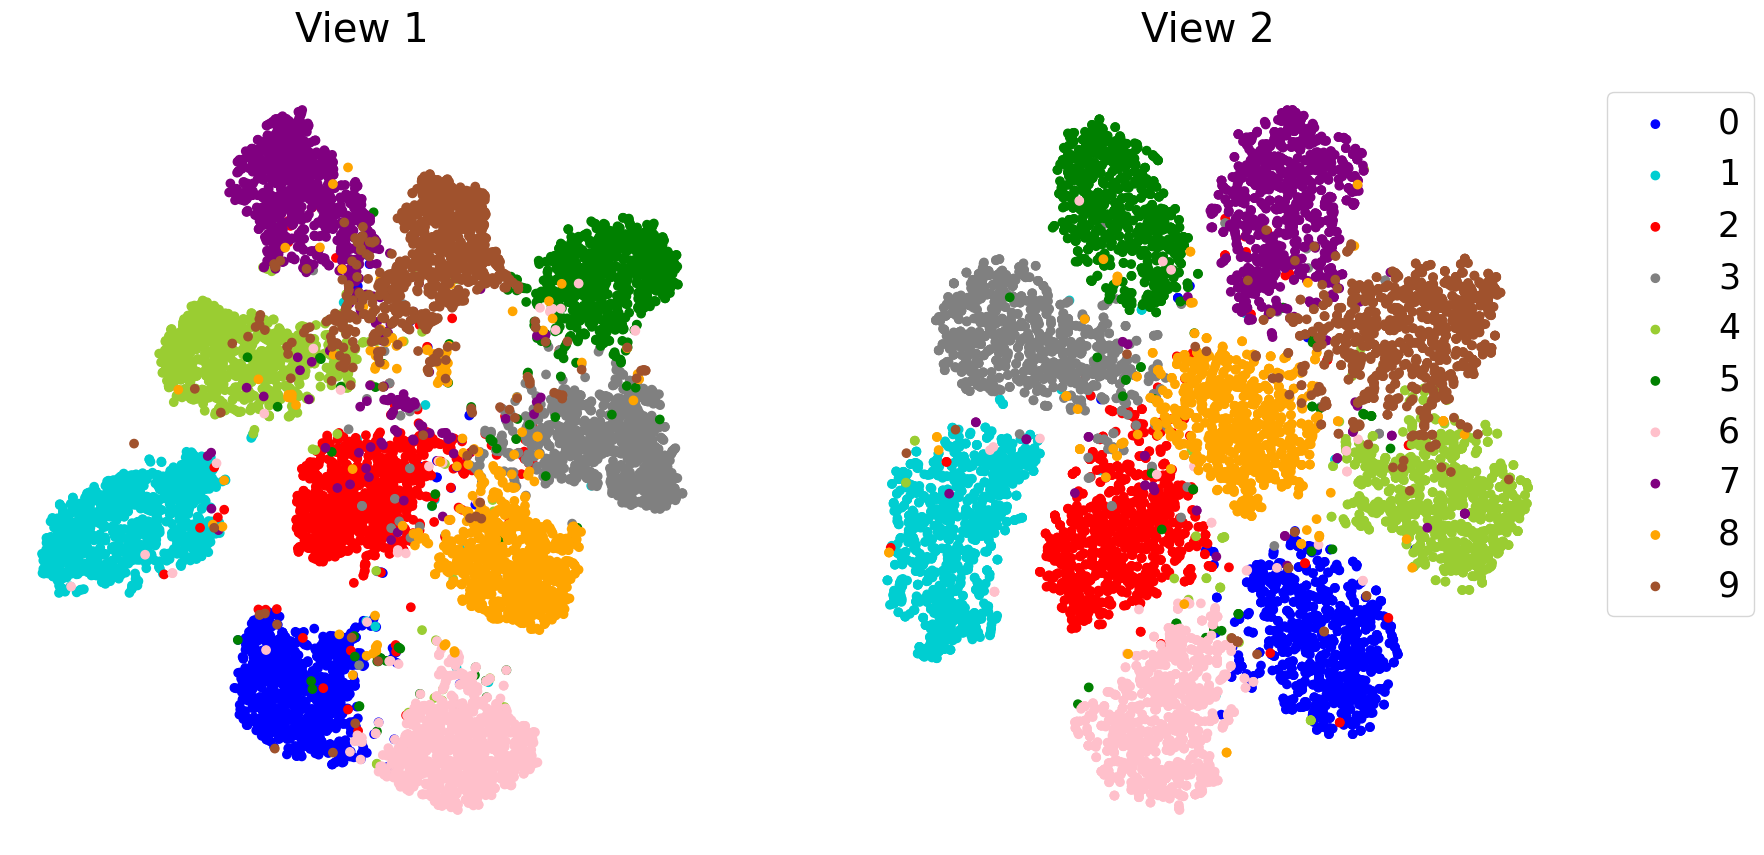

In [20]:
fig, axs = plt.subplots(1,2,figsize=(20,10))

colors = ['blue', 'darkturquoise', 'red', 'gray', 'yellowgreen', 'green', 'pink', 'purple', 'orange', 'sienna']

for label in np.unique(labels):
    i = np.where(labels == label)
    num_samples = embedding_0_net[i,0].shape[1]
    color = colors[label]
    
    axs[0].scatter(embedding_0_net[i,0], embedding_0_net[i,1], c=[color]*num_samples);
    axs[1].scatter(embedding_1_net[i,0], embedding_1_net[i,1], c=[color]*num_samples, label=label)

axs[0].set_title('View 1', fontsize=29, pad=25)
axs[1].set_title('View 2', fontsize=29, pad=25)

axs[1].legend(loc='upper right', prop=dict(size=25), bbox_to_anchor=(1.3, 1.0))

axs[0].axis('off');
axs[1].axis('off');

In [24]:
fig.savefig('mnist_cluster.png', bbox_inches='tight')

# CEGA

In [20]:
def comp_CEGA_explan(feature_dict):
    def visualize_rules(feature):
        show_rules(feature_dict[feature])
    
    feature_slider = widgets.IntSlider(
        min=0, max=len(explainer.shap_values_v0)-1, step=1, value=0
    )
    interact(visualize_rules, feature=feature_slider)

In [21]:
feature_dict = {}
for feature in tqdm(range(15)):
    rules_v0 = data_to_rules(view=0, feature_dim=feature, num_bins=5, shap_threshold=0.0025, min_support=0.08, confidence_threshold=0.8)
    rules_v1 = data_to_rules(view=1, feature_dim=feature, num_bins=5, shap_threshold=0.0025, min_support=0.08, confidence_threshold=0.8)
    
    pos_image_v0 = show_positive(rules_v0)
    neg_image_v0 = show_negative(rules_v0)
    pos_image_v1 = show_positive(rules_v1)
    neg_image_v1 = show_negative(rules_v1)
    
    feature_dict[feature] = {
        'v0_positive':pos_image_v0,
        'v0_negative':neg_image_v0,
        'v1_positive':pos_image_v1,
        'v1_negative':neg_image_v1   
    }
    

  0%|          | 0/15 [00:00<?, ?it/s]

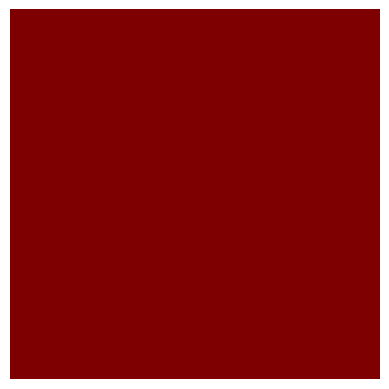

In [16]:
for feature in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]:
    for view in [0,1]:
        for direction in ['_positive', '_negative']:
            key = 'v'+str(view)+direction
            saving_name = 'mnist_cega_images_2/feature'+str(feature)+'_'+key+'.png'
            plt.imshow(feature_dict[feature][key]);
            plt.axis('off');
            plt.savefig(saving_name, bbox_inches='tight')

In [22]:
comp_CEGA_explan(feature_dict)

interactive(children=(IntSlider(value=0, description='feature', max=14), Output()), _dom_classes=('widget-inte…

In [23]:
representations_v0 = explainer.view0_representations
labels = explainer.test_labels[:500]

In [24]:
def show_composition(feature_dict, mean_values, num_features):
    composition_img = np.concatenate([np.ones((28,28,1))*0.5, np.zeros((28,28,2))], axis=2)
    weight_matrix = np.zeros((28,28))

    fig, axs = plt.subplots(2,num_features,figsize=(20,8))
    for i in range(num_features):
        if mean_values[i] > 0:
            img = feature_dict[i]['v0_positive']
        else:
            img = feature_dict[i]['v0_negative']

        tmp_img_0 = composition_img.copy()
        tmp_img_1 = img.copy()

        img_0_rules_pixel = np.equal(tmp_img_0[:,:,0], tmp_img_0[:,:,1])
        img_1_rules_pixel = np.equal(tmp_img_1[:,:,0], tmp_img_1[:,:,1])
        common_rules_pixel = np.logical_and(img_0_rules_pixel, img_1_rules_pixel)
        excl_img_0_rules_pixel = (img_0_rules_pixel*1-common_rules_pixel*1).astype(bool)
        excl_img_1_rules_pixel = (img_1_rules_pixel*1-common_rules_pixel*1).astype(bool)

        weight_matrix[img_1_rules_pixel] += 1
        
        composition_img[excl_img_0_rules_pixel, :] = tmp_img_0[excl_img_0_rules_pixel, :]
        composition_img[excl_img_1_rules_pixel, :] = tmp_img_1[excl_img_1_rules_pixel, :]
        composition_img[common_rules_pixel, :] = tmp_img_0[common_rules_pixel, :] + tmp_img_1[common_rules_pixel, :]

        tmp_vis = composition_img.copy()
        tmp_vis[weight_matrix != 0] /= weight_matrix[weight_matrix != 0][:,None]

        axs[0,i].imshow(img)
        axs[0,i].axis('off')
        axs[1,i].imshow(tmp_vis)
        axs[1,i].axis('off')

    fig.tight_layout()

In [25]:
num_features = 5

## Zeros

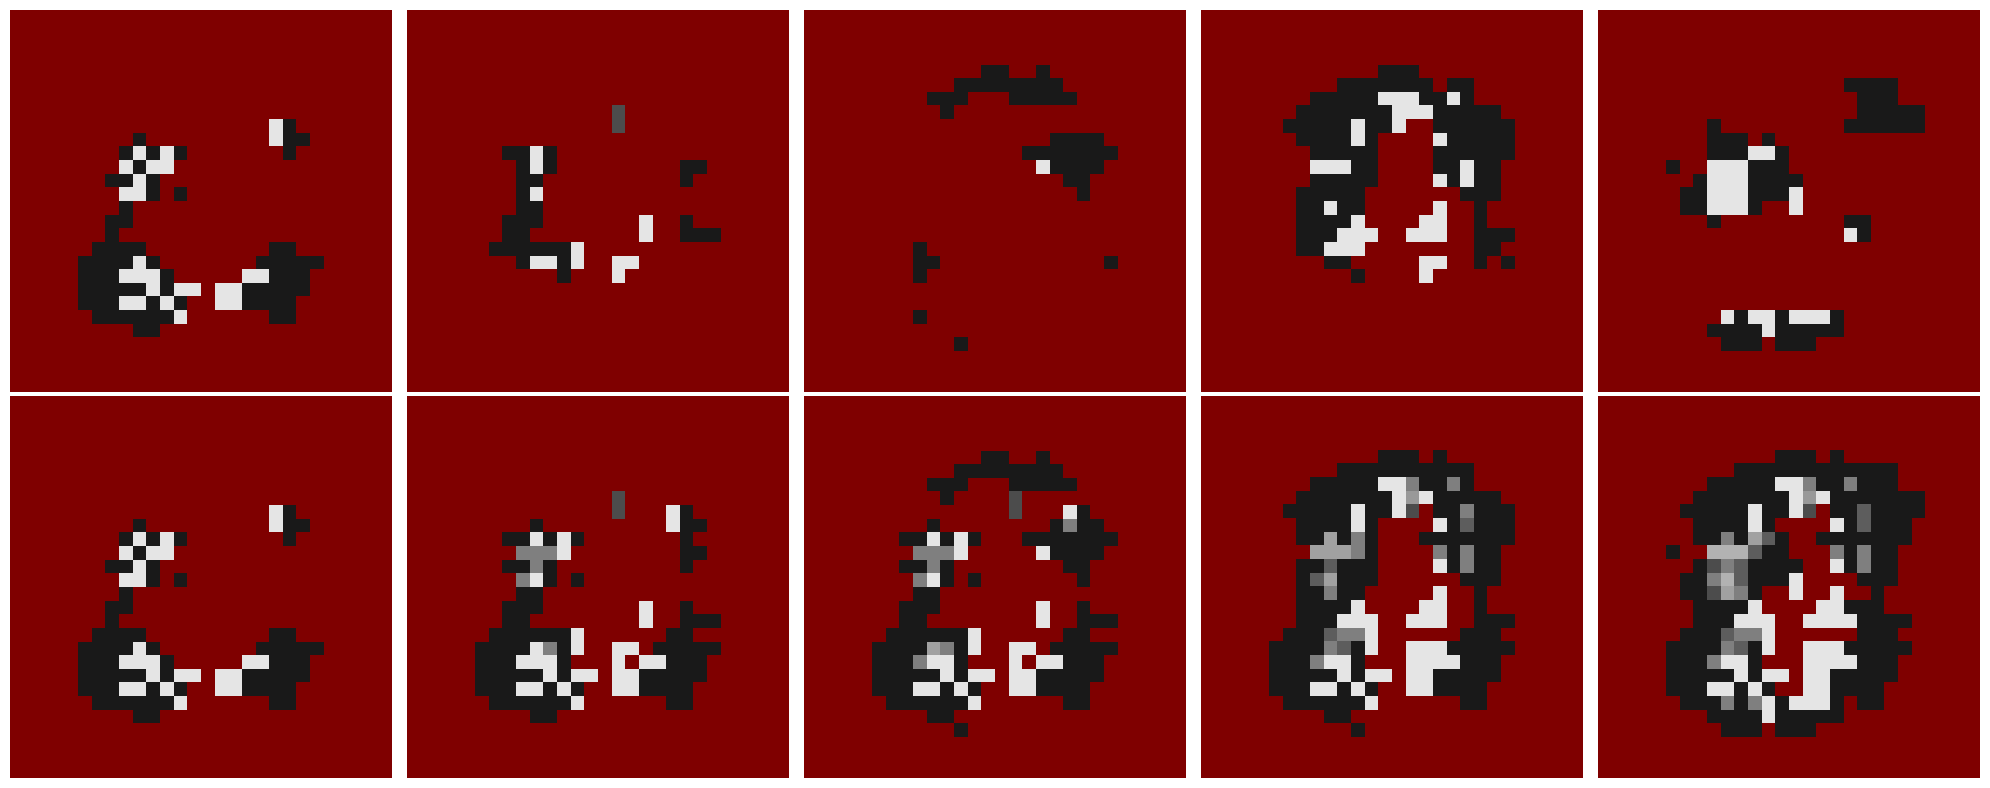

In [21]:
show_composition(
    feature_dict, tf.reduce_mean(representations_v0[labels==0], axis=0).numpy()[:num_features], num_features
)

## Ones

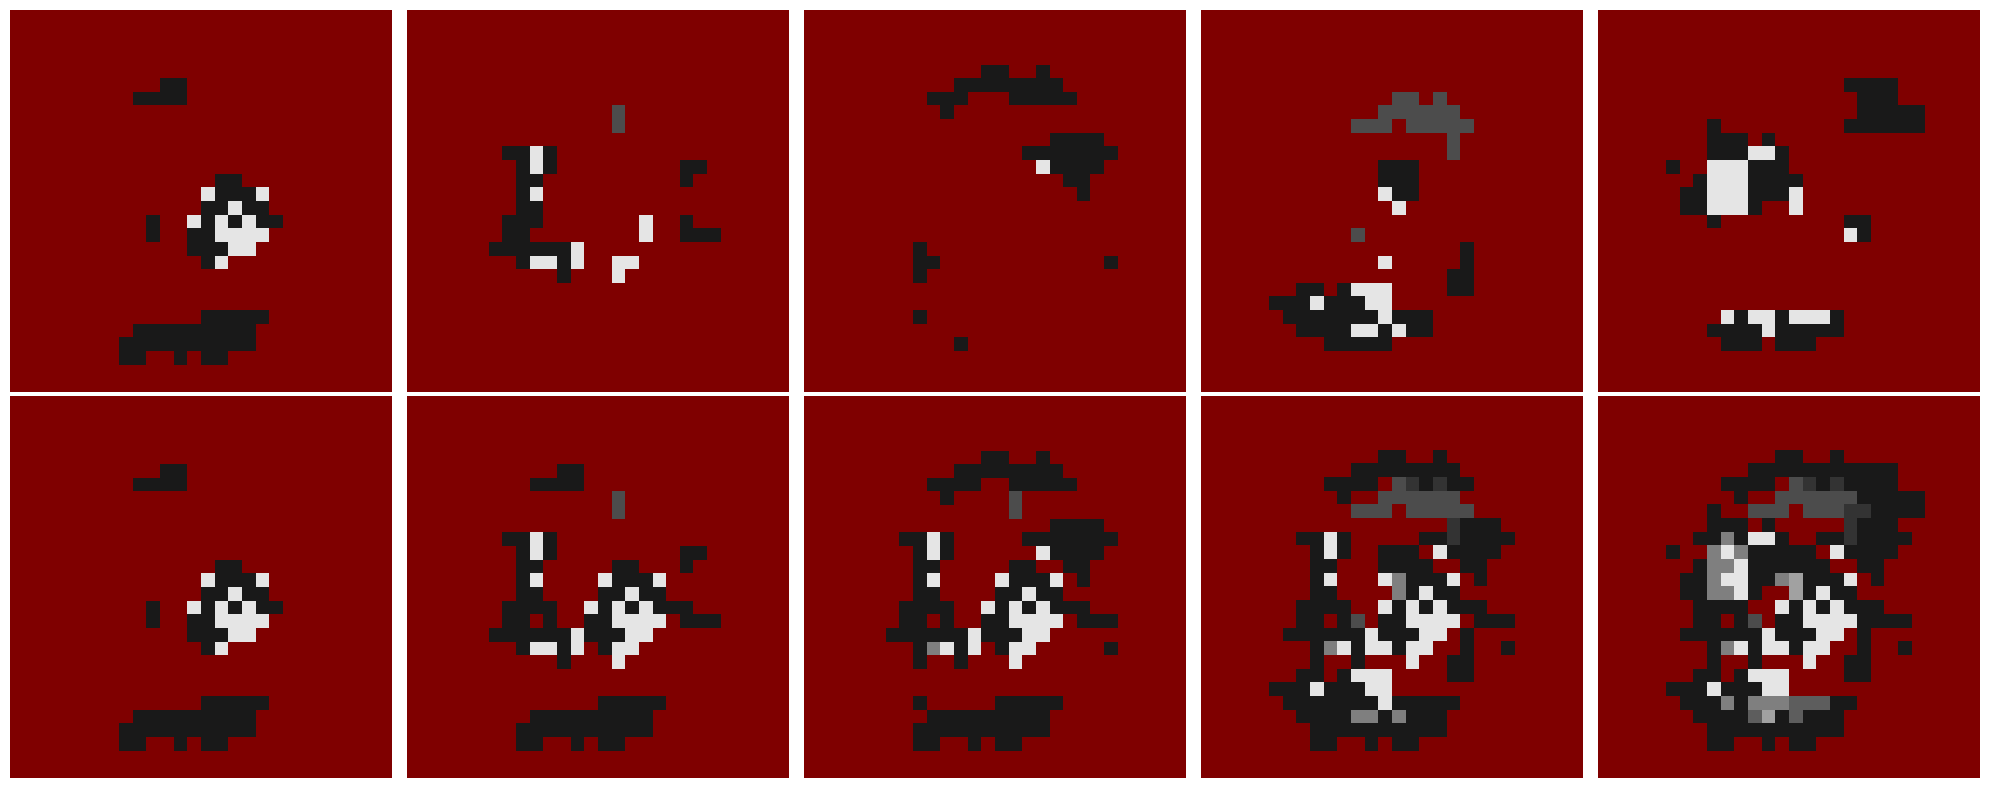

In [22]:
show_composition(
    feature_dict, tf.reduce_mean(representations_v0[labels==1], axis=0).numpy()[:num_features], num_features
)

## Twos

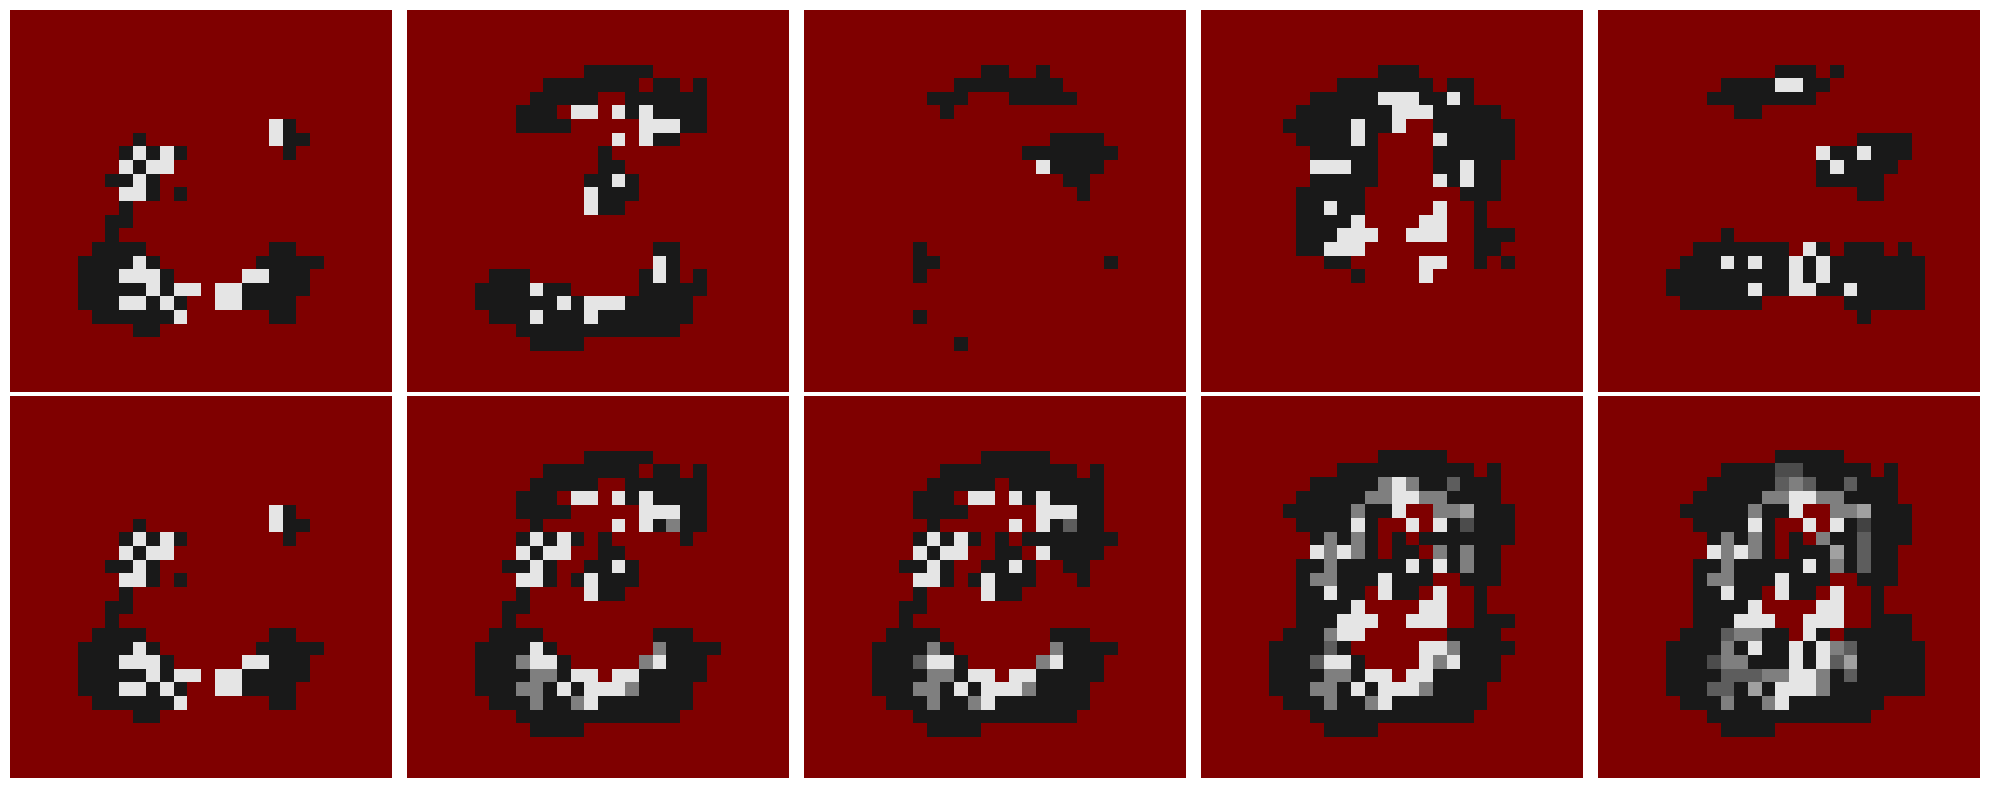

In [23]:
show_composition(
    feature_dict, tf.reduce_mean(representations_v0[labels==2], axis=0).numpy()[:num_features], num_features
)

# Threes

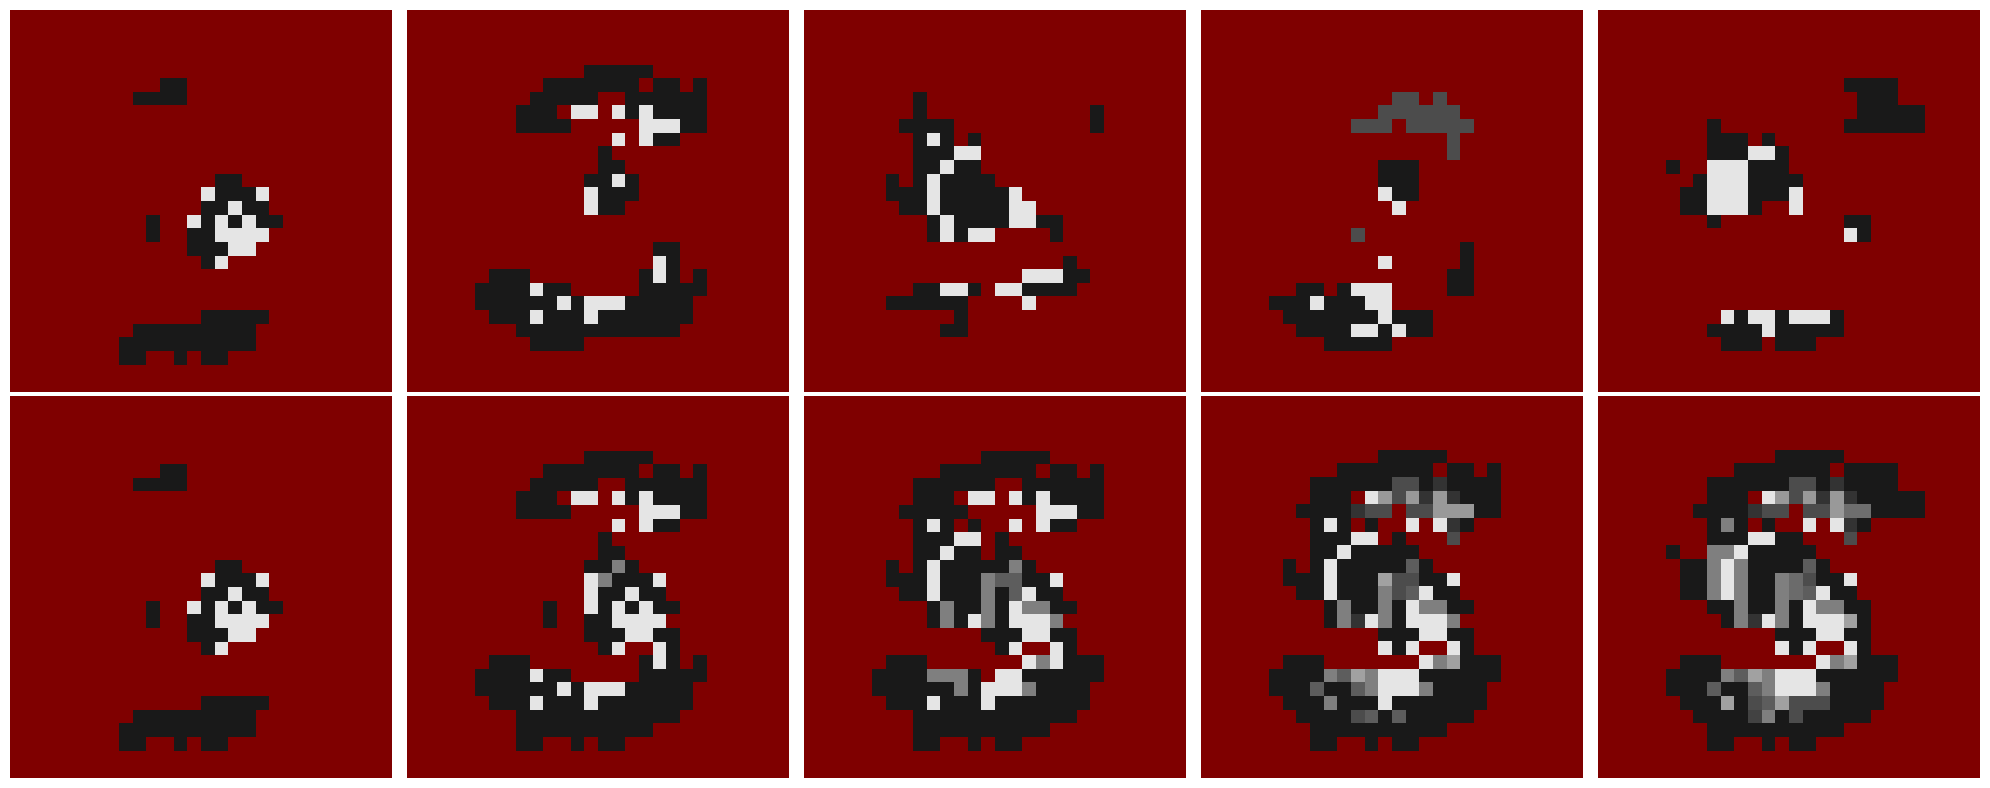

In [24]:
show_composition(
    feature_dict, tf.reduce_mean(representations_v0[labels==3], axis=0).numpy()[:num_features], num_features
)

## Fours

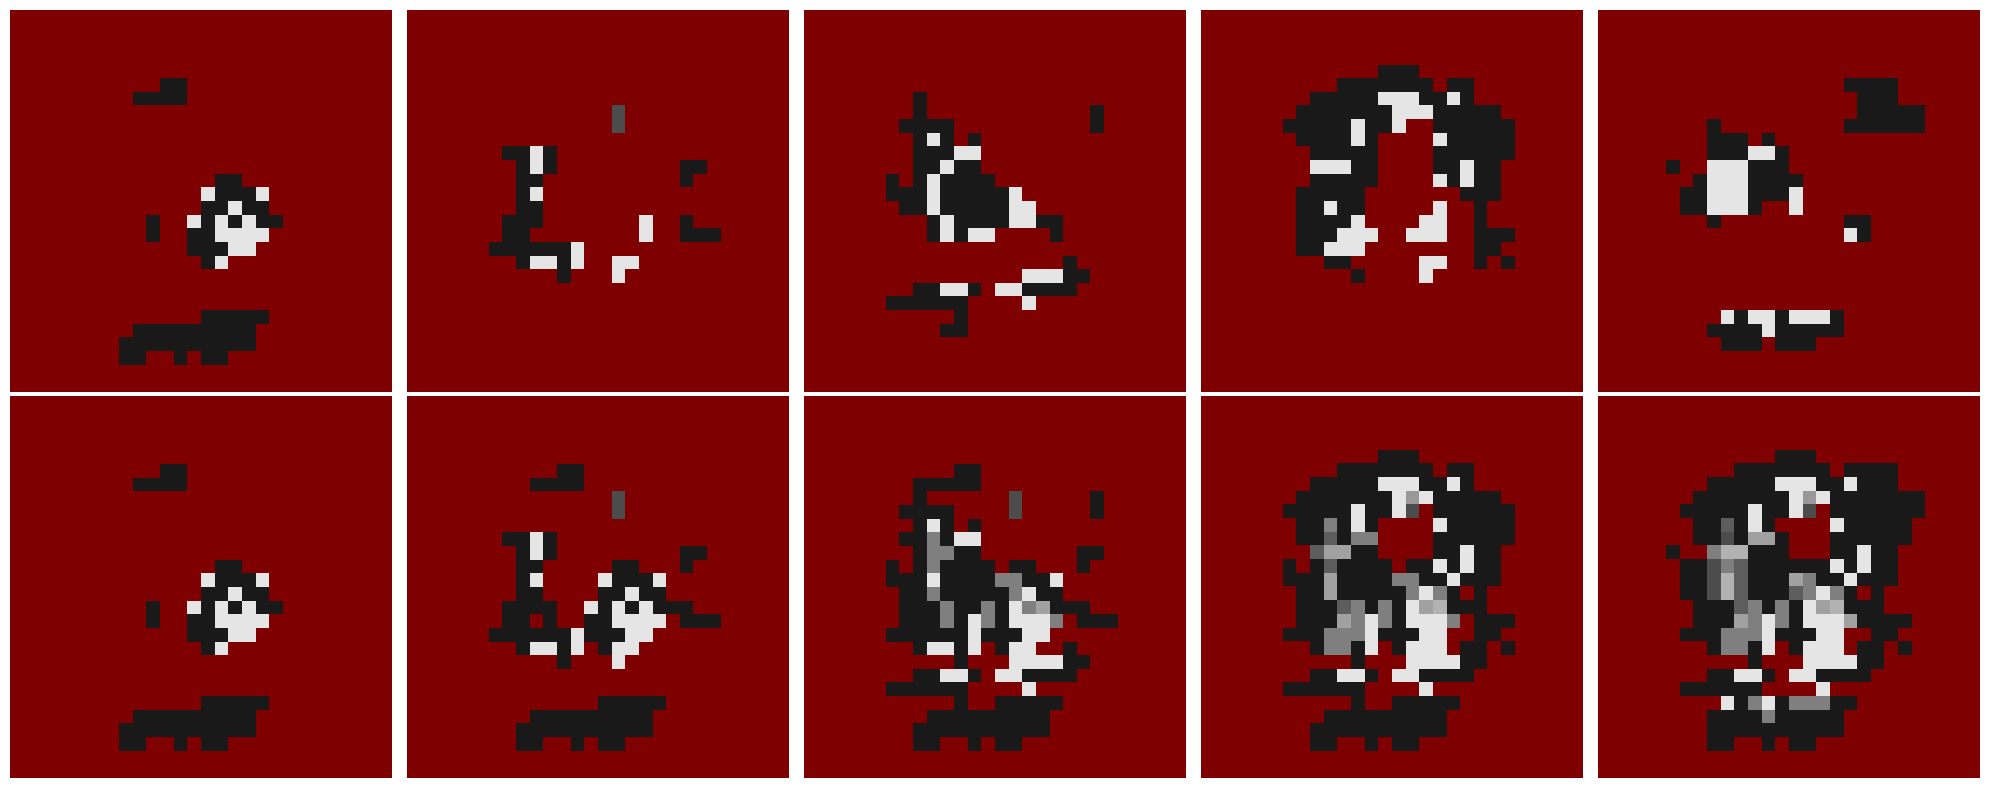

In [25]:
show_composition(
    feature_dict, tf.reduce_mean(representations_v0[labels==4], axis=0).numpy()[:num_features], num_features
)

## Fives

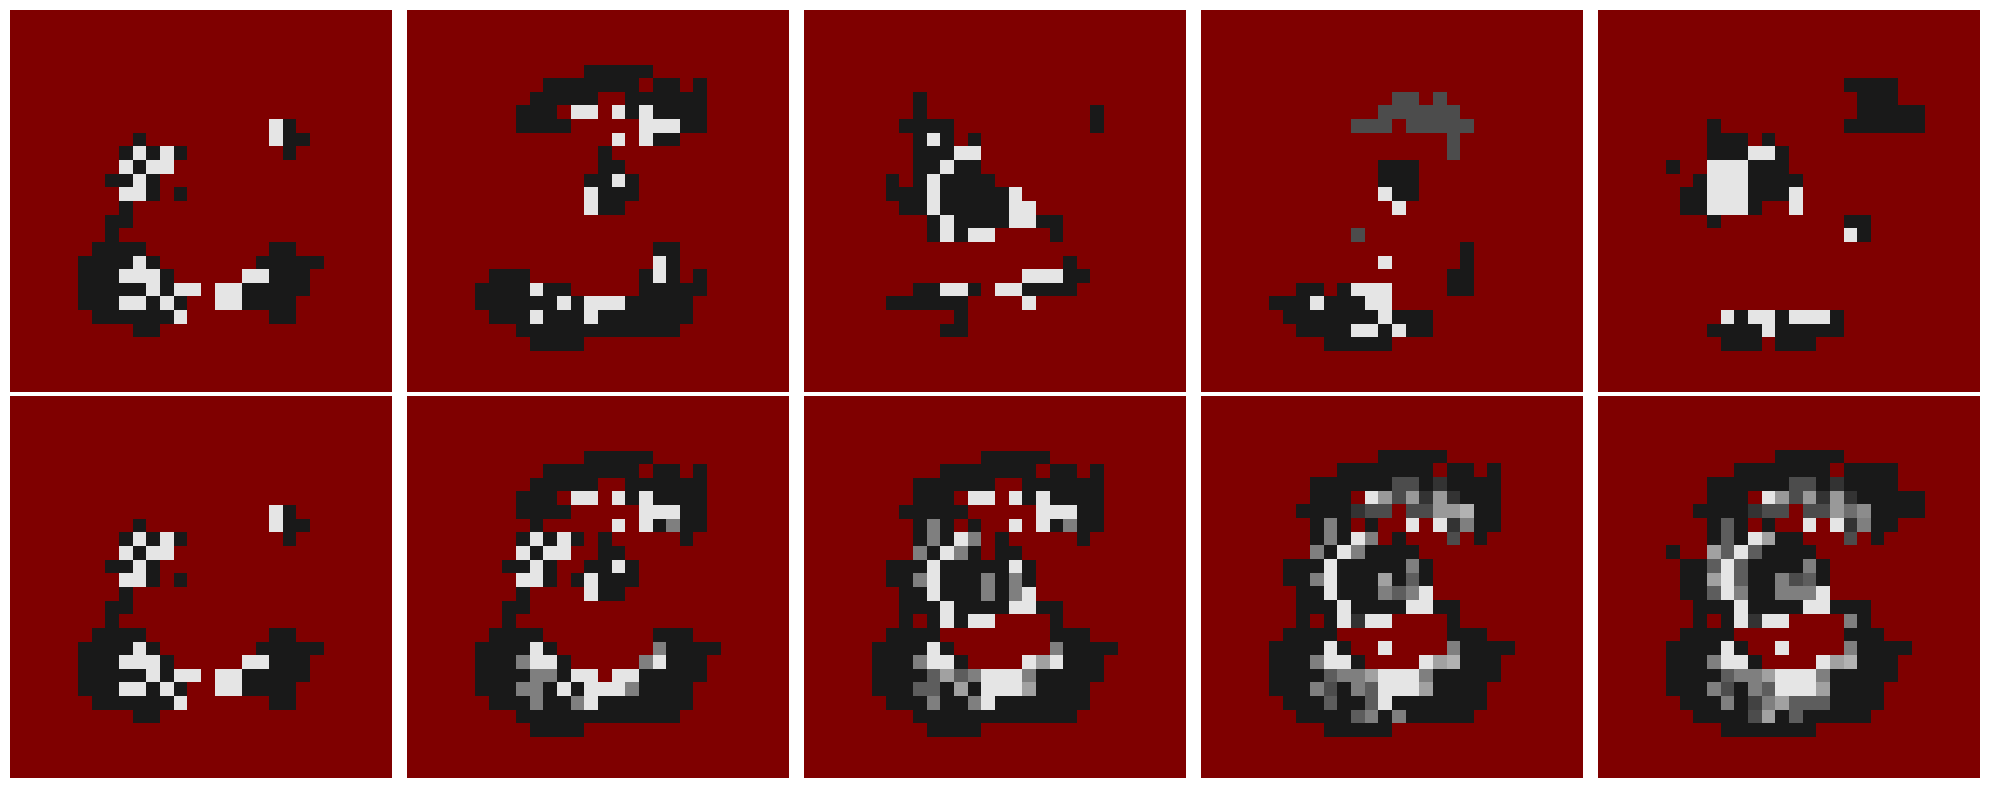

In [26]:
show_composition(
    feature_dict, tf.reduce_mean(representations_v0[labels==5], axis=0).numpy()[:num_features], num_features
)

## Sixes

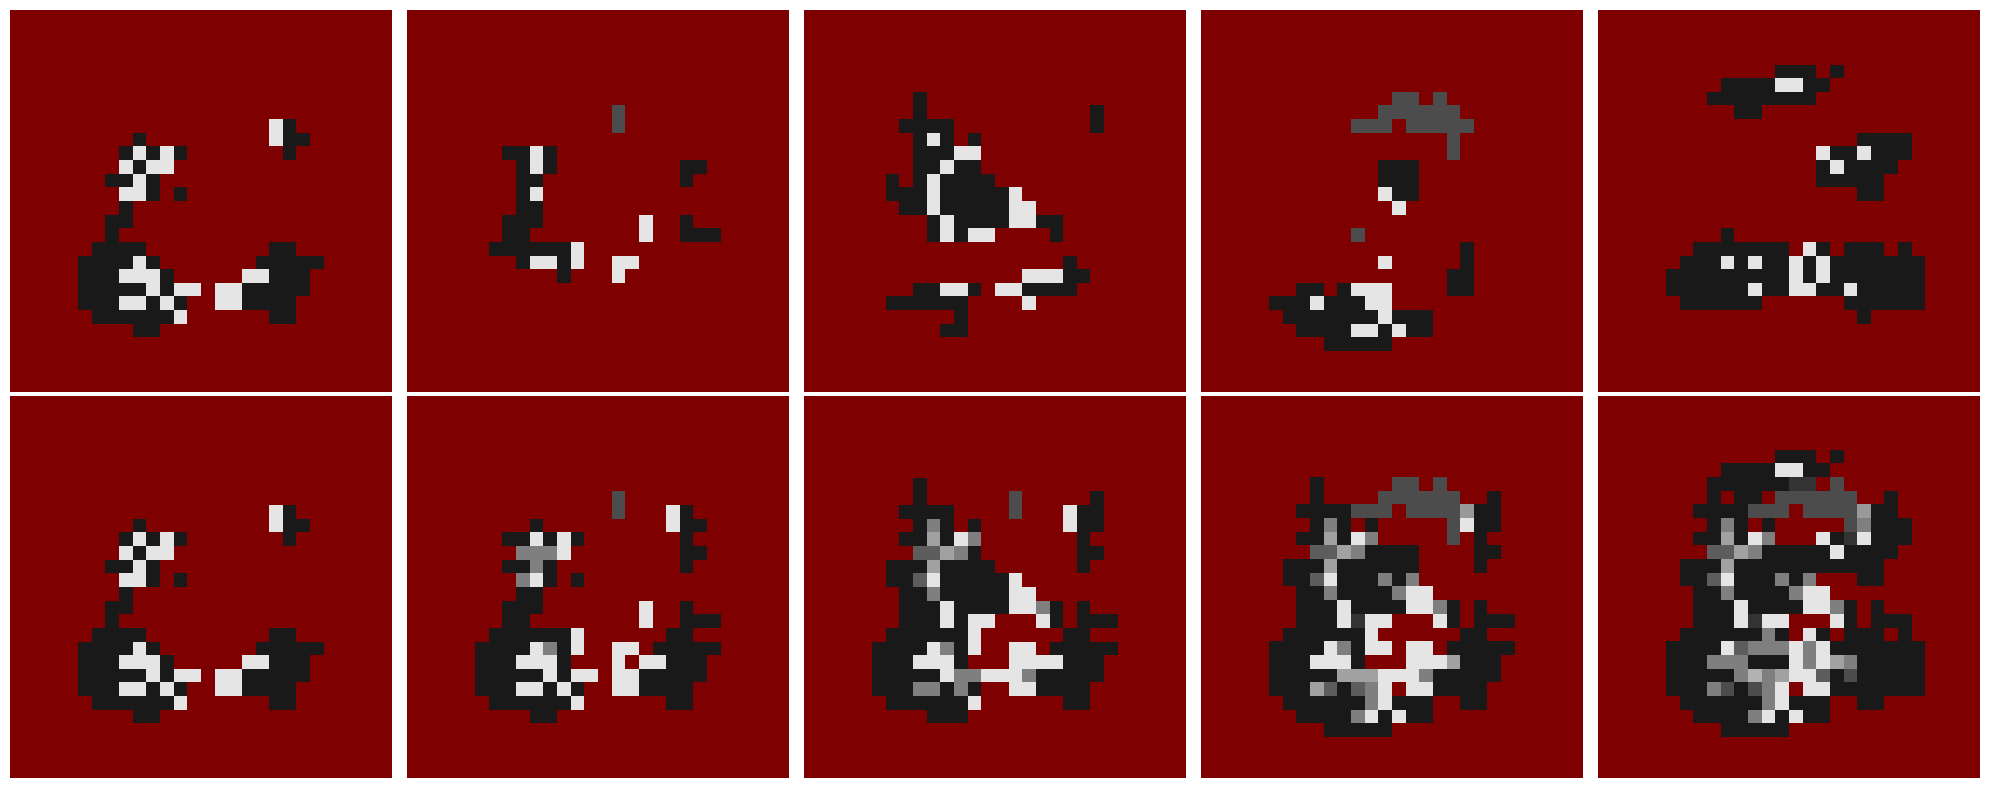

In [27]:
show_composition(
    feature_dict, tf.reduce_mean(representations_v0[labels==6], axis=0).numpy()[:num_features], num_features
)

## Sevens

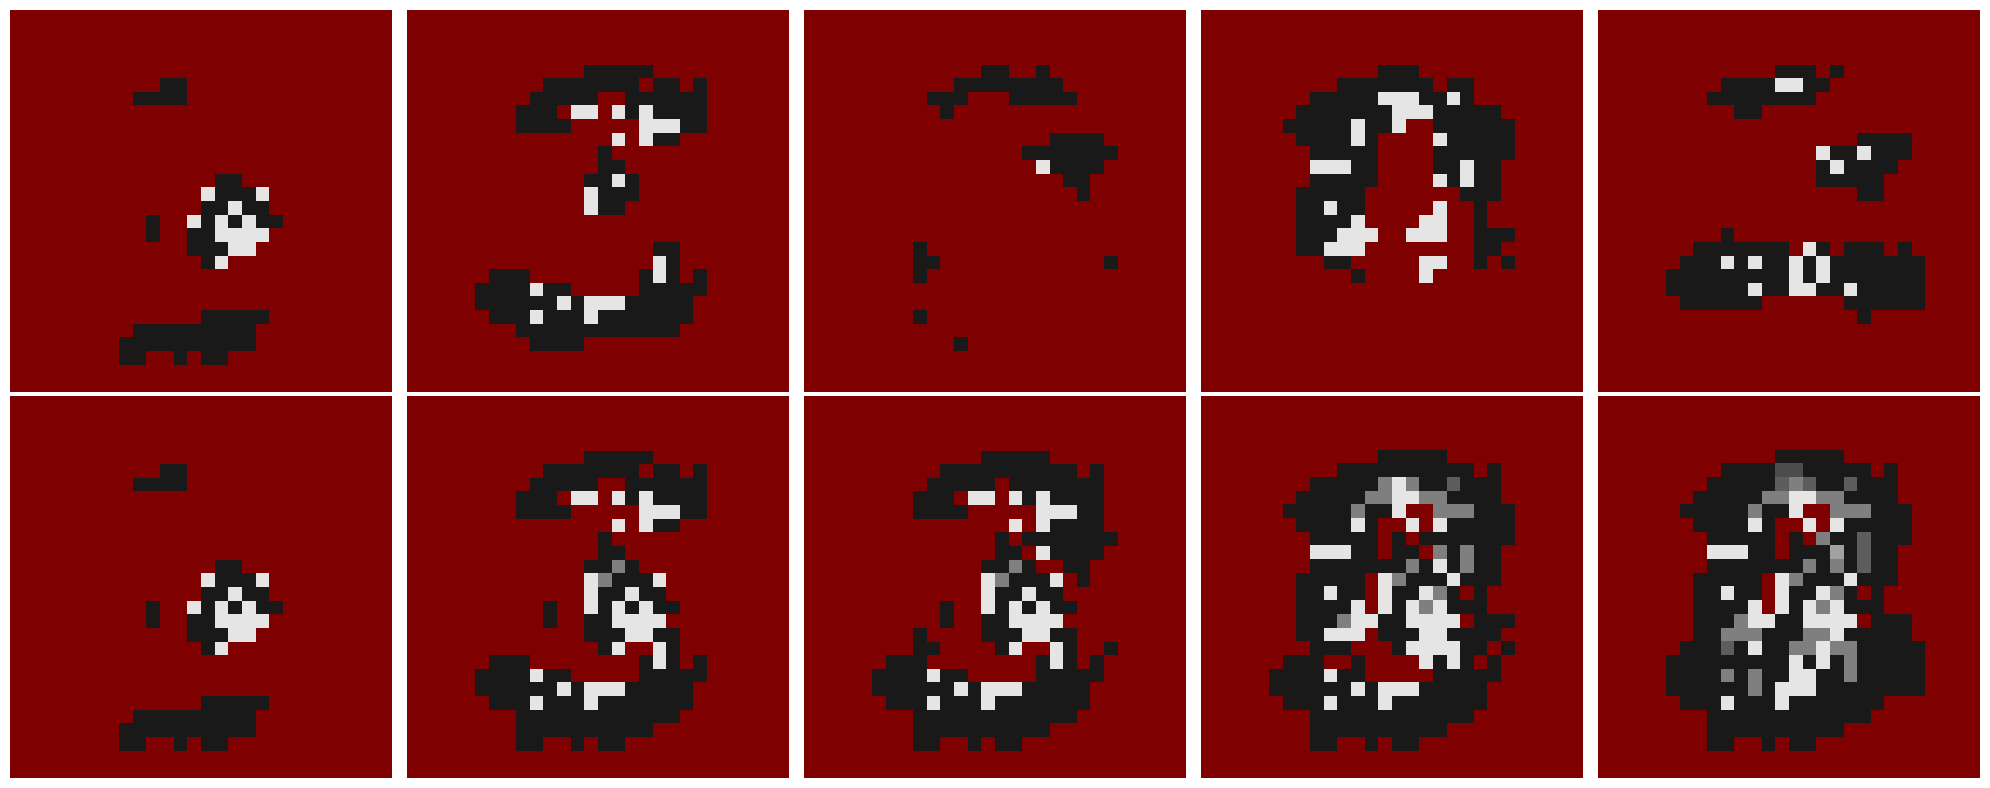

In [28]:
show_composition(
    feature_dict, tf.reduce_mean(representations_v0[labels==7], axis=0).numpy()[:num_features], num_features
)

## Eights

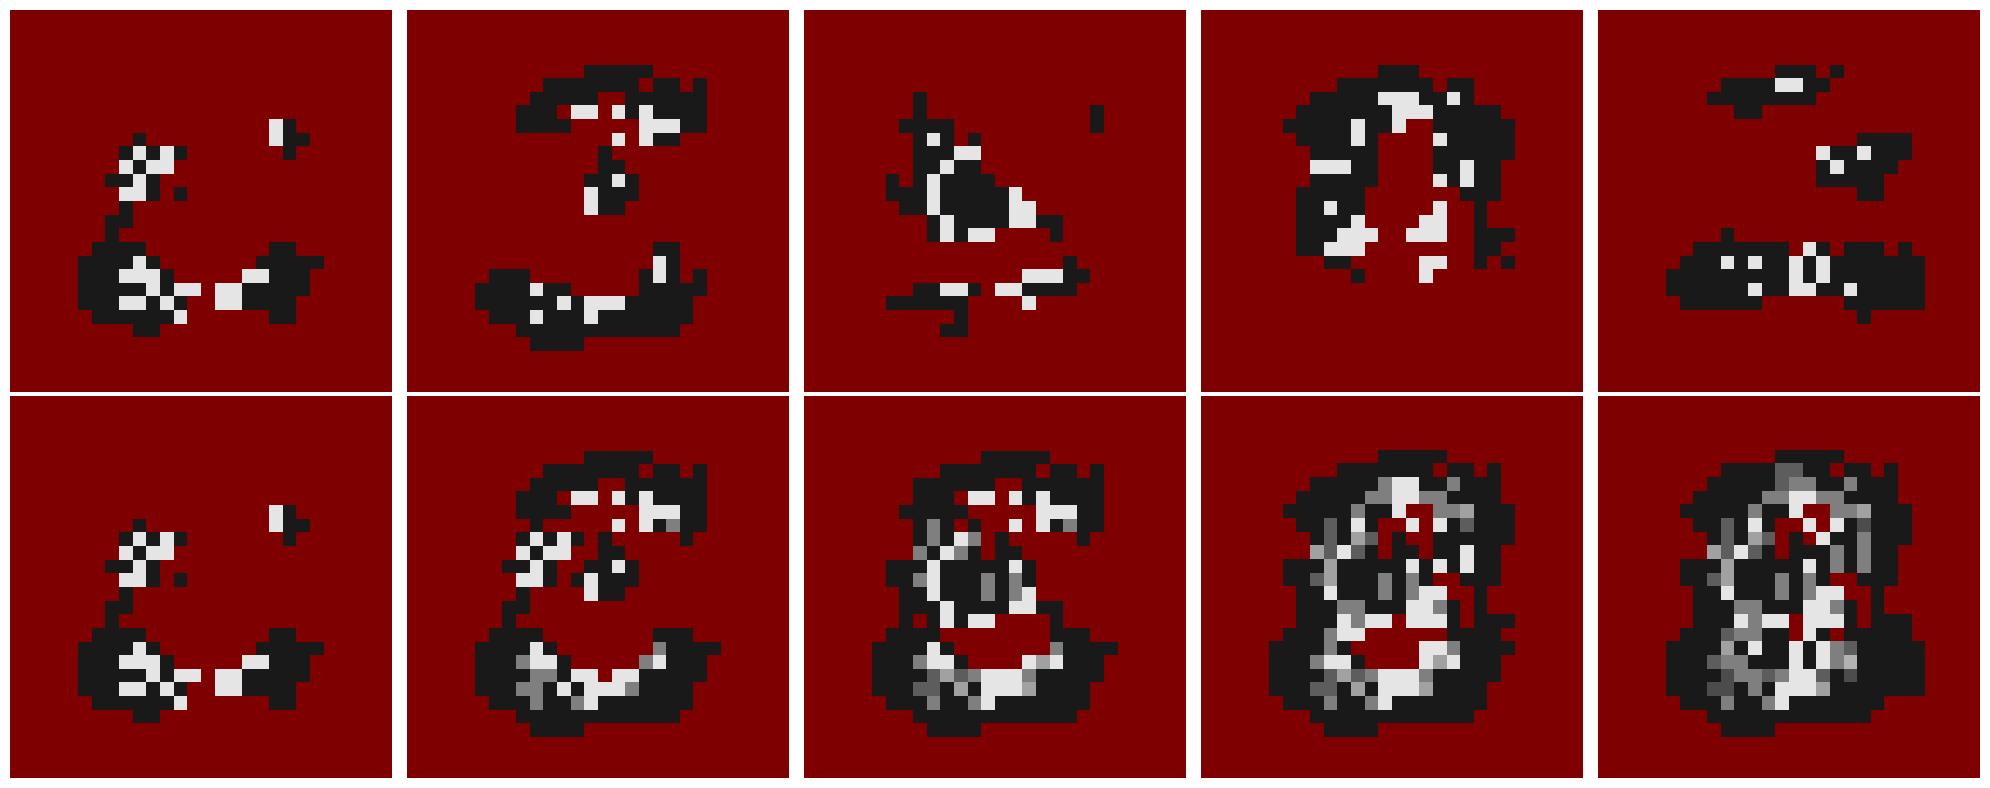

In [29]:
show_composition(
    feature_dict, tf.reduce_mean(representations_v0[labels==8], axis=0).numpy()[:num_features], num_features
)

## Nines

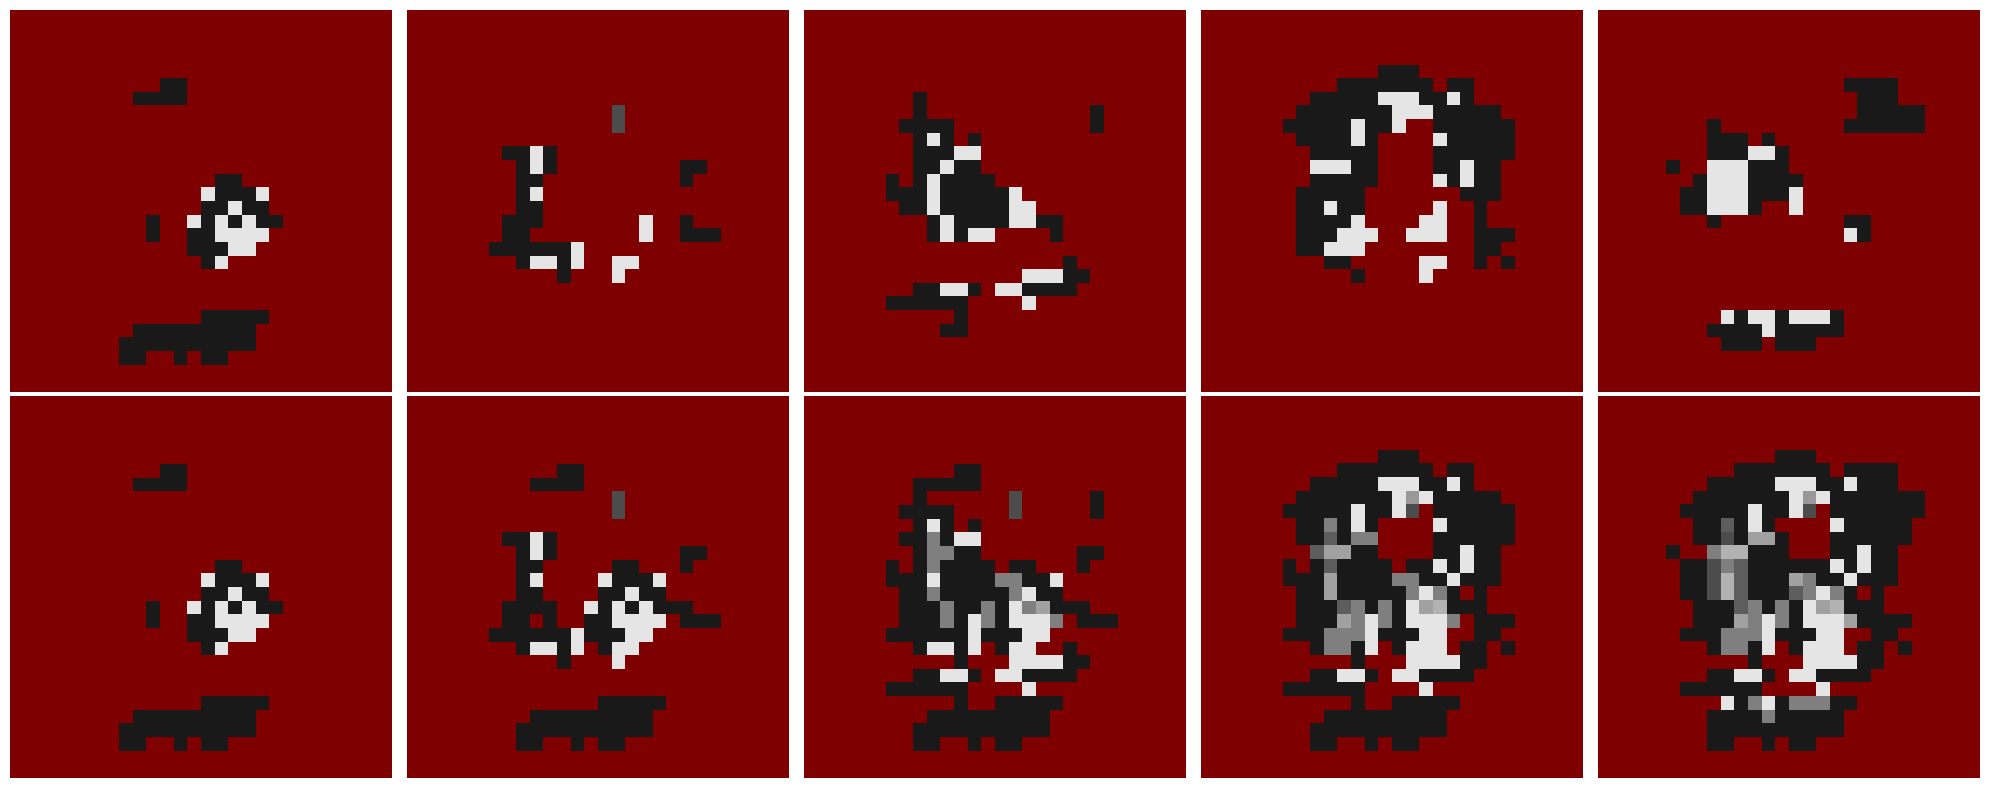

In [30]:
show_composition(
    feature_dict, tf.reduce_mean(representations_v0[labels==9], axis=0).numpy()[:num_features], num_features
)